# Readme
Ce notebook est pour analyse le taux de abs non excusé par rapport le temps en utilisant le transformation de Fourier.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
from datetime import datetime

sns.set_theme("notebook")

In [2]:
df3 = pd.read_csv('../données_brut/export_rdv_2023-01-01-2023-12-31.csv', sep=';')
df3 = df3[df3['Motif du RDV'].isin(['Adulte - Consultation de médecine générale','enfant/ado - consultation de médecine générale', 'Consultation de médecine du sport',"Certificat d'aptitude au sport"])]
df_temps = df3[["Date de début","Statut"]]

/tmp/ipykernel_71336/79073498.py:1: DtypeWarning: Columns (45,46,47,48,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('../données_brut/export_rdv_2023-01-01-2023-12-31.csv', sep=';')


In [3]:
day_map = {
    'Absent excusé': 'Absent excusé',
    'Absent non excusé': 'Absent non excusé',
    'Vu' : 'Présent',
    'À déplacer': 'Absent excusé',
    'À venir': 'Absent non excusé',
    'En attente': 'Présent',
    'En consultation': 'Présent'    
}

df_temps['Statut'] = df_temps['Statut'].map(day_map)

df_temps['Absent_non_excuse'] = df_temps['Statut'] == 'Absent non excusé'
df_temps.head()

/tmp/ipykernel_71336/1513993834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temps['Statut'] = df_temps['Statut'].map(day_map)
/tmp/ipykernel_71336/1513993834.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temps['Absent_non_excuse'] = df_temps['Statut'] == 'Absent non excusé'


,Date de début,Statut,Absent_non_excuse
0,02/01/2023,Absent excusé,False
4,02/01/2023,Absent excusé,False
5,02/01/2023,Absent excusé,False
8,02/01/2023,Absent excusé,False
9,02/01/2023,Absent excusé,False


In [4]:
df_temps['Date de début'] = pd.to_datetime(df_temps['Date de début'], format='%d/%m/%Y')

df_temps = df_temps.groupby('Date de début').agg(
    taux_absent_non_excuse=('Absent_non_excuse', 'mean'),
    rdv_nb=('Absent_non_excuse', 'count')
).reset_index()

/tmp/ipykernel_71336/578059825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temps['Date de début'] = pd.to_datetime(df_temps['Date de début'], format='%d/%m/%Y')


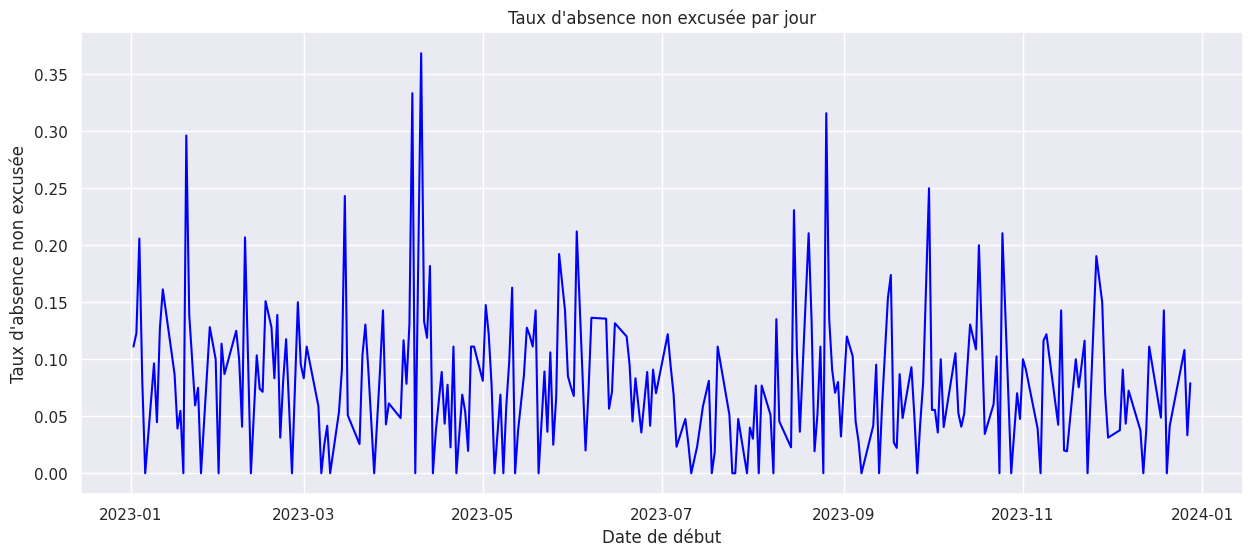

In [5]:
plt.figure(figsize=(15, 6))
plt.plot(df_temps['Date de début'], df_temps['taux_absent_non_excuse'], color='blue')
plt.xlabel('Date de début')
plt.ylabel('Taux d\'absence non excusée')
plt.title('Taux d\'absence non excusée par jour')
plt.show()

In [6]:
idx = np.argmax(df_temps['taux_absent_non_excuse'])
df_temps.iloc[idx]

Date de début             2023-04-10 00:00:00
taux_absent_non_excuse               0.368421
rdv_nb                                     19
Name: 67, dtype: object

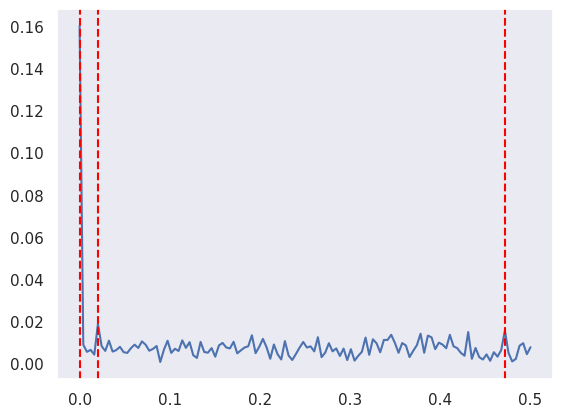

In [7]:
# reproduie le graphique par le 3 fréauence la plus grande 
from scipy.fftpack import fft
import numpy as np

# Number of sample points
N = len(df_temps)
# sample spacing
T = 1.0
x = np.linspace(0.0, N*T, N)
y = df_temps['taux_absent_non_excuse'].values
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

# Find the 3 highest frequencies
freqs = np.argsort(np.abs(yf[0:N//2]))[-3:]
for freq in freqs:
    plt.axvline(x=xf[freq], color='red', linestyle='--')
plt.show()

# Find the 3 highest frequencies

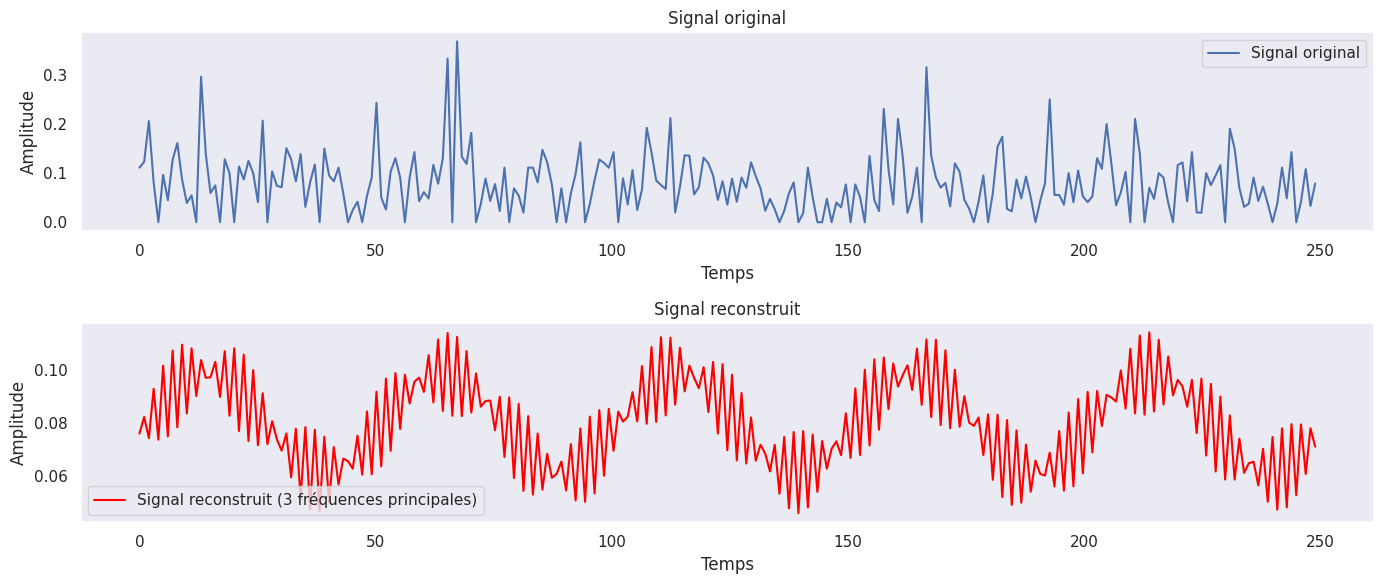

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Nombre de points d'échantillonnage
N = len(df_temps)
# Espacement des échantillons
T = 1.0
x = np.linspace(0.0, N*T, N)
y = df_temps['taux_absent_non_excuse'].values

# Effectuer la FFT
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Trouver les 3 fréquences les plus importantes
indices_frequences_importantes = np.argsort(np.abs(yf[0:N//2]))[-3:]

# Créer un spectre de fréquences contenant seulement les 3 fréquences les plus importantes
yf_reduit = np.zeros_like(yf)
yf_reduit[indices_frequences_importantes] = yf[indices_frequences_importantes]
yf_reduit[-indices_frequences_importantes] = yf[-indices_frequences_importantes]

# Effectuer l'iFFT pour obtenir le signal temporel reconstruit
signal_reconstruit = ifft(yf_reduit)

# Tracer le signal original et le signal reconstruit
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(x, y, label='Signal original')
plt.title('Signal original')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, signal_reconstruit.real, label='Signal reconstruit (3 fréquences principales)', color='red')
plt.title('Signal reconstruit')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
df_week = df3[["Date de début","Statut"]].copy()
df_week['Statut'] = df_week['Statut'].map(day_map)
df_week['Absent_non_excuse'] = df_week['Statut'] == 'Absent non excusé'
df_week['Date de début'] = pd.to_datetime(df_week['Date de début'], format='%d/%m/%Y')
df_week['week'] = df_week['Date de début'].dt.isocalendar().week
df_week.head()


,Date de début,Statut,Absent_non_excuse,week
0,2023-01-02,Absent excusé,False,1
4,2023-01-02,Absent excusé,False,1
5,2023-01-02,Absent excusé,False,1
8,2023-01-02,Absent excusé,False,1
9,2023-01-02,Absent excusé,False,1


In [10]:
df_week = df_week.groupby('week').agg(
    taux_absent_non_excuse=('Absent_non_excuse', 'mean'),
    rdv_nb=('Absent_non_excuse', 'count')
).reset_index()

df_week.head()

,week,taux_absent_non_excuse,rdv_nb
0,1,0.131757,296
1,2,0.105455,275
2,3,0.099526,211
3,4,0.063725,204
4,5,0.102564,195


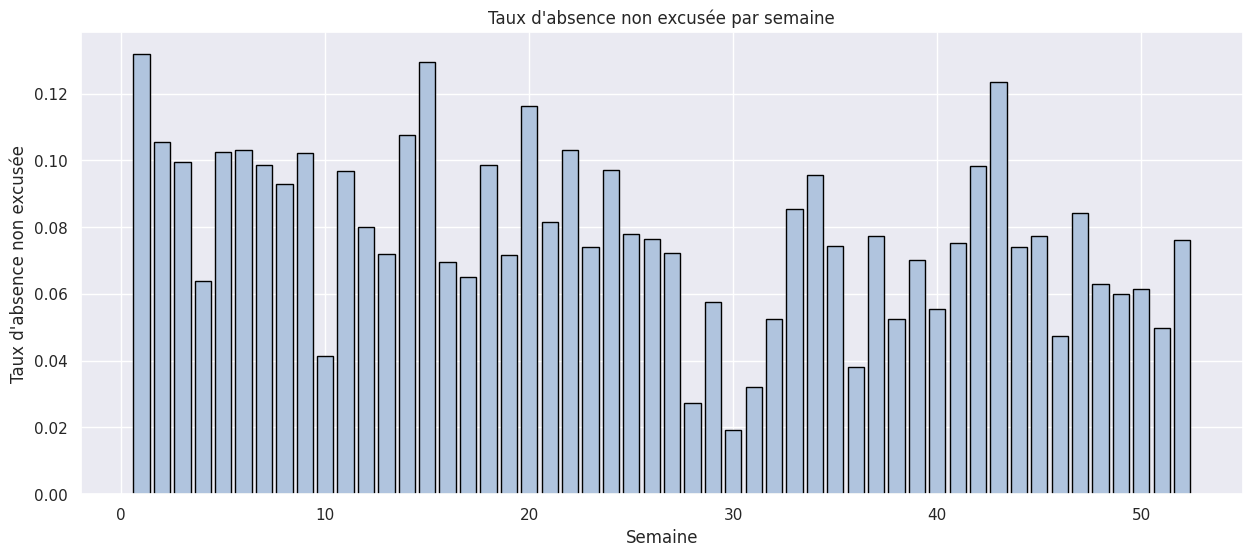

In [11]:
plt.figure(figsize=(15, 6))
#palette = sns.color_palette("viridis", )
plt.bar(df_week['week'], df_week['taux_absent_non_excuse'], edgecolor='black', color='#B0C4DE')
#sns.barplot(x=df_week['week'], y=df_week['taux_absent_non_excuse'], palette=palette, edgecolor='black')
#plt.plot(df_week['week'], df_week['taux_absent_non_excuse'], color='blue')
plt.xlabel('Semaine')
plt.ylabel('Taux d\'absence non excusée')
plt.title('Taux d\'absence non excusée par semaine')
plt.show()

[0.01428571 0.00285714 0.        ]


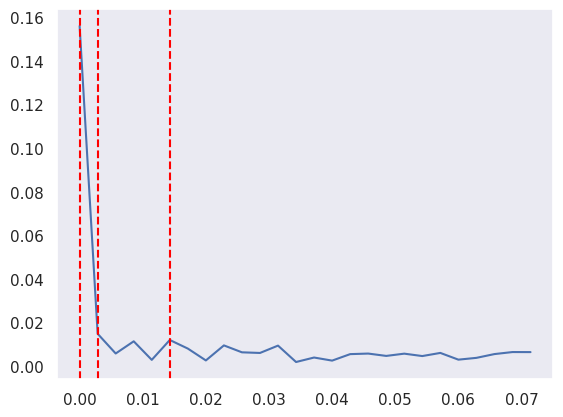

In [12]:
from scipy.fftpack import fft
import numpy as np

# Number of sample points
N = len(df_week)
# sample spacing
T = 7.0
x = np.linspace(0.0, N*T, N)
y = df_week['taux_absent_non_excuse'].values
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()

# Find the 3 highest frequencies
freqs = np.argsort(np.abs(yf[0:N//2]))[-3:]
print(xf[freqs])
for freq in freqs:
    plt.axvline(x=xf[freq], color='red', linestyle='--')
plt.show()

# Find the 3 highest frequencies

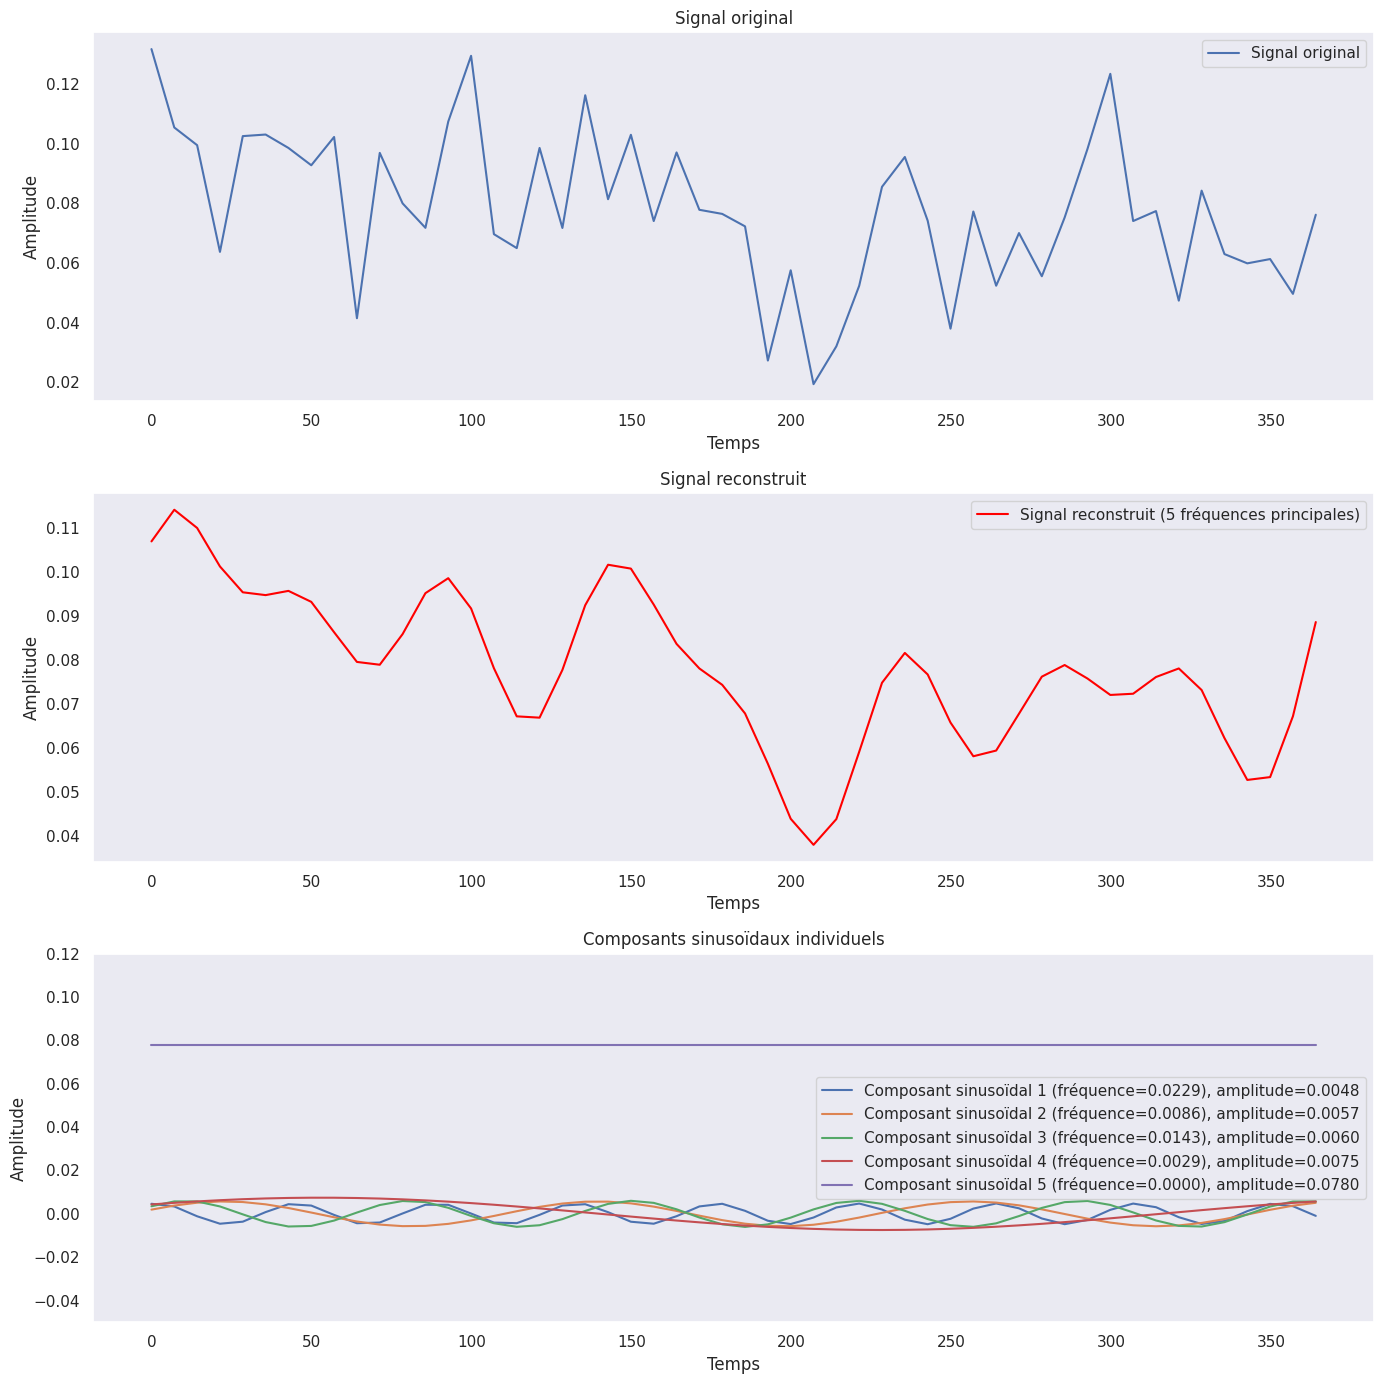

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Nombre de points d'échantillonnage
N = len(df_week)
# Espacement des échantillons
T = 7.0
x = np.linspace(0.0, N*T, N)
y = df_week['taux_absent_non_excuse'].values

# Effectuer la FFT
yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# Trouver les 3 fréquences les plus importantes
n_freq = 5
indices_frequences_importantes = np.argsort(np.abs(yf[0:N//2]))[-n_freq:]

# Créer un spectre de fréquences contenant seulement les n fréquences les plus importantes
yf_reduit = np.zeros_like(yf)
yf_reduit[indices_frequences_importantes] = yf[indices_frequences_importantes]
yf_reduit[-indices_frequences_importantes] = yf[-indices_frequences_importantes]


# Effectuer l'iFFT pour obtenir le signal temporel reconstruit
signal_reconstruit = ifft(yf_reduit)

# Tracer le signal original et le signal reconstruit
plt.figure(figsize=(14, 14))

plt.subplot(3, 1, 1)
plt.plot(x, y, label='Signal original')
plt.title('Signal original')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(x, signal_reconstruit.real, label=f'Signal reconstruit ({n_freq} fréquences principales)', color='red')
plt.title('Signal reconstruit')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

#sinusoidal_component = np.zeros_like(x)
#Tracer les 3 composants sinusoïdaux individuels
plt.subplot(3, 1, 3)

for i, idx in enumerate(indices_frequences_importantes):
    amplitude = 1.0*np.abs(yf[idx]) / N 
    phase = np.angle(yf[idx])
    frequency = xf[idx]
    sinusoidal_component = amplitude * np.cos(2 * np.pi * frequency * x + phase)
    plt.plot(x, sinusoidal_component, label=f'Composant sinusoïdal {i+1} (fréquence={frequency:.4f}), amplitude={amplitude:.4f}')
    plt.ylim(-0.05, 0.12)


plt.title('Composants sinusoïdaux individuels')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
df_mon = df3[["Date de début","Statut"]].copy()
df_mon['Statut'] = df_mon['Statut'].map(day_map)
df_mon['Absent_non_excuse'] = df_mon['Statut'] == 'Absent non excusé'
df_mon['Date de début'] = pd.to_datetime(df_mon['Date de début'], format='%d/%m/%Y')
df_mon['month'] = df_mon['Date de début'].dt.month
df_mon.head()

,Date de début,Statut,Absent_non_excuse,month
0,2023-01-02,Absent excusé,False,1
4,2023-01-02,Absent excusé,False,1
5,2023-01-02,Absent excusé,False,1
8,2023-01-02,Absent excusé,False,1
9,2023-01-02,Absent excusé,False,1


In [15]:
df_mon = df_mon.groupby('month').agg(
    taux_absent_non_excuse=('Absent_non_excuse', 'mean'),
    rdv_nb=('Absent_non_excuse', 'count')
).reset_index()

df_mon.head(12)

,month,taux_absent_non_excuse,rdv_nb
0,1,0.103152,1047
1,2,0.100112,889
2,3,0.073850,826
3,4,0.095436,964
4,5,0.090367,1007
5,6,0.087483,743
6,7,0.045378,595
7,8,0.071757,1087
8,9,0.063549,834
9,10,0.080132,911


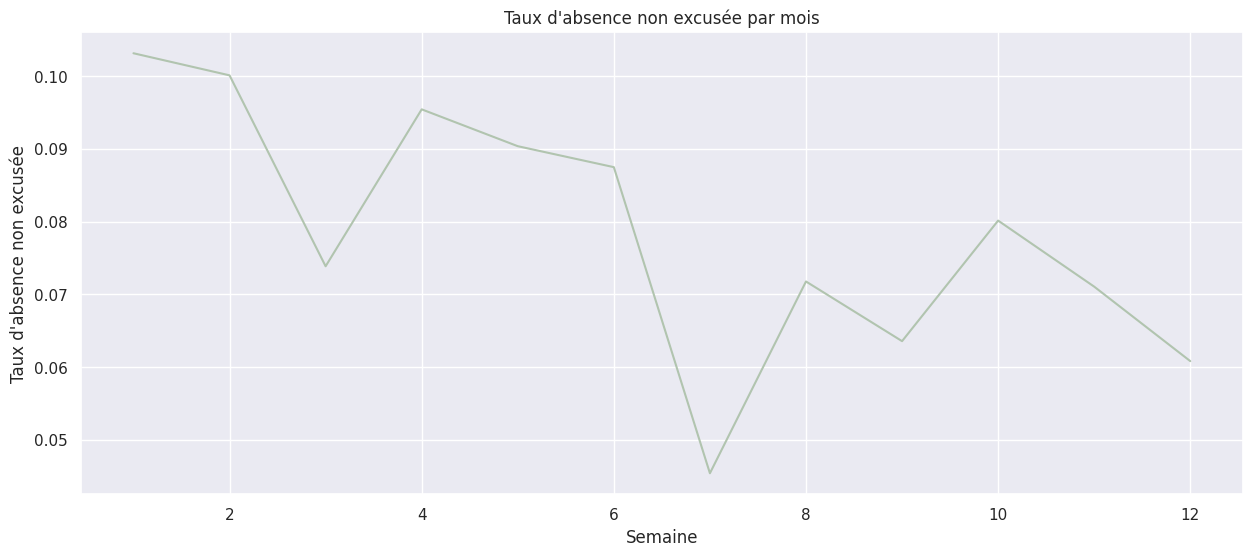

In [16]:
plt.figure(figsize=(15, 6))
#palette = sns.color_palette("viridis", )
#plt.bar(df_mon['month'], df_mon['taux_absent_non_excuse'], edgecolor='black', color='#B1C4AF')
plt.plot(df_mon['month'], df_mon['taux_absent_non_excuse'], color='#B1C4AF')
plt.xlabel('Semaine')
plt.ylabel('Taux d\'absence non excusée')
plt.title('Taux d\'absence non excusée par mois')
plt.show()